# World Happiness Report 2015–2019 Analysis
This notebook explores how global happiness has evolved across five years of World Happiness Report data. We focus on comparing countries and regions, uncovering drivers of happiness, and highlighting notable shifts in well-being around the world.

**Research questions**
- How do global happiness scores change from 2015 to 2019?
- Which countries improved or declined the most across the five-year span?
- How do regions and continents differ in their happiness trajectories?
- Which factors show the strongest relationships with happiness over time?

In [1]:
from pathlib import Path
import sys
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


# 0 Normalize and merge data 
### ⚠️ Out of this assignments scope - might be deleted in future
We load all yearly CSV files, harmonize their schemas, and combine them into a unified dataset with consistent country and region labels. Cleaning includes standardizing column names, resolving naming differences across years, and enriching each record with region and continent metadata.

In [2]:
# Ensure project root is on sys.path so we can import local modules
PROJECT_ROOT = Path.cwd()
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

from data_preprocessor import process_and_save_data

# Check if processed data exists, if not, generate it
processed_file = PROJECT_ROOT / "happiness_combined_2015_2019.csv"
if not processed_file.exists():
    print("Processed data not found. Running data normalization pipeline...")
    process_and_save_data()
    print("Data processing complete!")


## 1. Load Data

Load the happiness dataset from the pre-processed CSV file.

In [3]:
processed_file = PROJECT_ROOT / "happiness_combined_2015_2019.csv"
if not processed_file.exists():
    raise FileNotFoundError(f"Processed data file missing at {processed_file}. Run the setup cell first.")

# Load the pre-processed data directly from CSV
happiness = pd.read_csv(processed_file)
print(f"Loaded {len(happiness)} records from {happiness['year'].min()} to {happiness['year'].max()}")
happiness.head()


Loaded 782 records from 2015 to 2019


,country,region,continent,year,happiness_score,gdp_per_capita,social_support,healthy_life_expectancy,freedom,generosity,corruption_perception
0,Switzerland,Western Europe,Europe,2015,7.587,1.39651,1.34951,0.94143,0.66557,0.29678,0.41978
1,Iceland,Northern Europe,Europe,2015,7.561,1.30232,1.40223,0.94784,0.62877,0.43630,0.14145
2,Denmark,Northern Europe,Europe,2015,7.527,1.32548,1.36058,0.87464,0.64938,0.34139,0.48357
3,Norway,Northern Europe,Europe,2015,7.522,1.45900,1.33095,0.88521,0.66973,0.34699,0.36503
4,Canada,North America,North America,2015,7.427,1.32629,1.32261,0.90563,0.63297,0.45811,0.32957


The unified DataFrame contains 5 years of observations with harmonized naming, region, and continent metadata. The descriptive statistics above provide a quick health check before diving into exploratory analysis.

## 2. Global Exploratory Visualizations
We first explore how global happiness has evolved over time, examining central tendencies and distributional changes between 2015 and 2019.

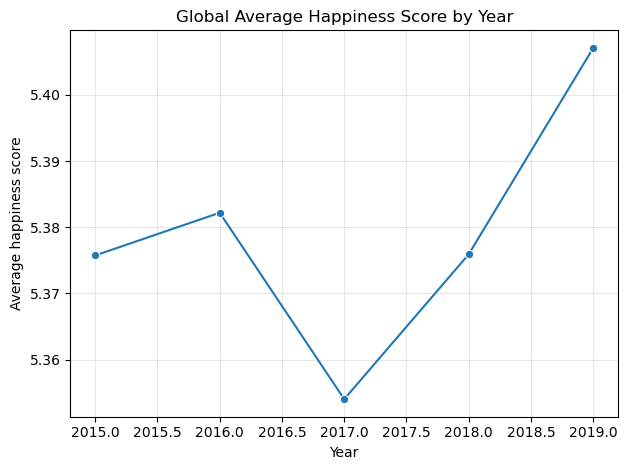

In [4]:
avg_scores = happiness.groupby("year")["happiness_score"].mean().reset_index()
fig, ax = plt.subplots()
sns.lineplot(data=avg_scores, x="year", y="happiness_score", marker="o", ax=ax)
ax.set_title("Global Average Happiness Score by Year")
ax.set_ylabel("Average happiness score")
ax.set_xlabel("Year")
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


Global happiness levels remain remarkably stable, with only subtle improvements after 2017 and a slight softening in 2019. The absence of dramatic swings suggests broad resilience in average well-being during this period.

2025-11-29 13:20:08 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-11-29 13:20:08 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


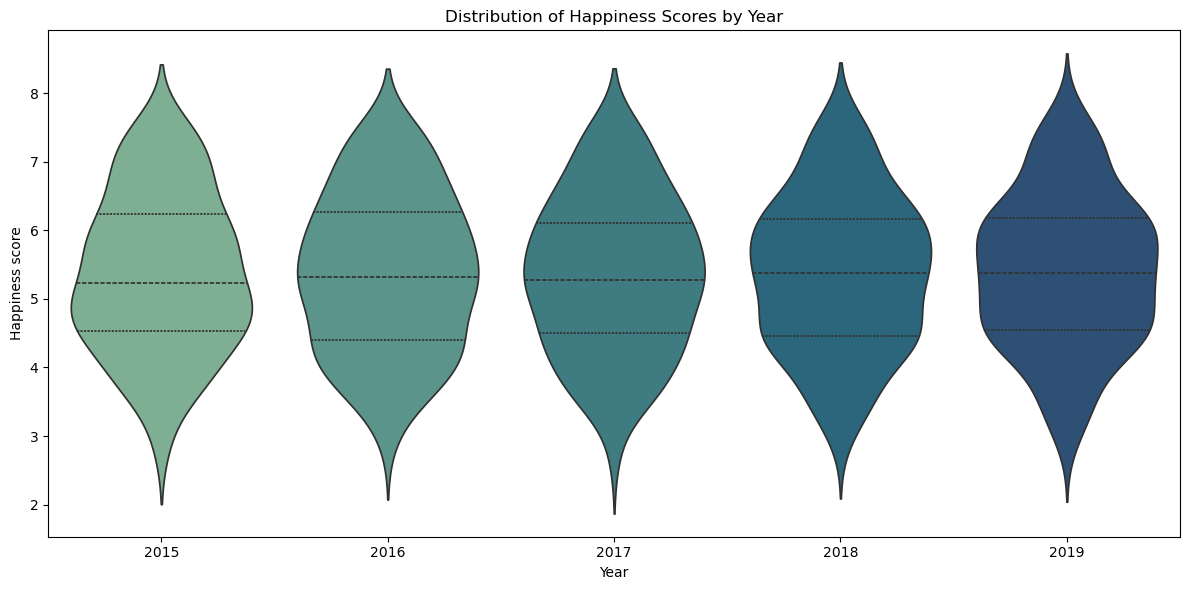

In [5]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.violinplot(data=happiness, x="year", y="happiness_score", palette="crest", inner="quartile", ax=ax)
ax.set_title("Distribution of Happiness Scores by Year")
ax.set_ylabel("Happiness score")
ax.set_xlabel("Year")
plt.tight_layout()
plt.show()


Score distributions are consistently right-skewed: most countries cluster between 3 and 6, while a small group sustains scores above 7. The interquartile range narrows slightly after 2016, hinting at modest convergence.

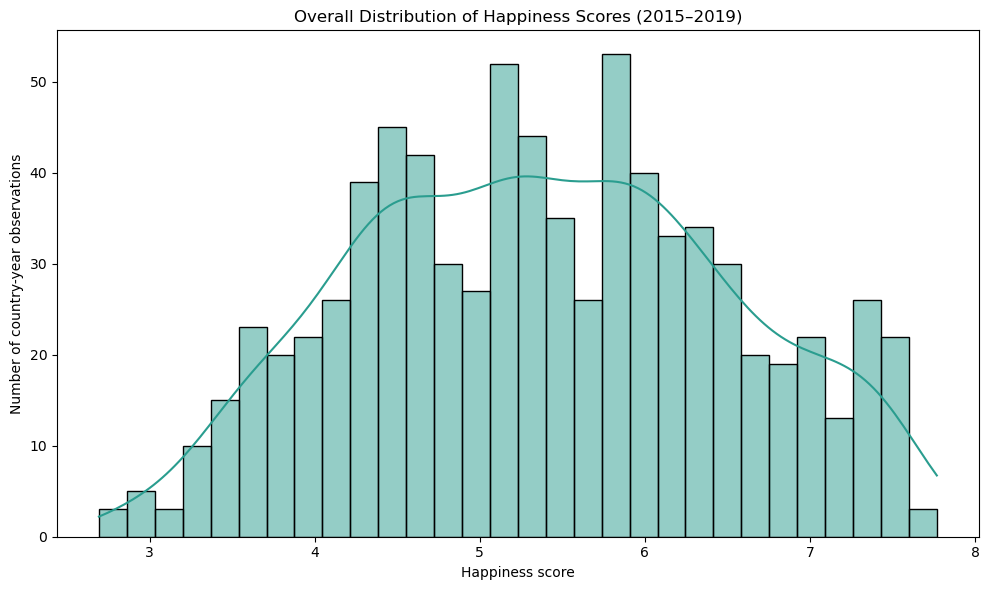

In [6]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(data=happiness, x="happiness_score", bins=30, kde=True, color="#2a9d8f", ax=ax)
ax.set_title("Overall Distribution of Happiness Scores (2015–2019)")
ax.set_xlabel("Happiness score")
ax.set_ylabel("Number of country-year observations")
plt.tight_layout()
plt.show()


The histogram highlights a long tail of lower-scoring observations while the density peak sits near 5.5. Improvements above 7.5 are rare, underscoring how difficult it is for countries to sustain exceptional happiness levels.

## 3. Regional and Country-Level Patterns
Next we contrast regions and countries to uncover divergent trajectories and highlight the largest movers over the five-year window.

### 3.1 Regional trajectories
We compare region-level averages to show shared momentum and persistent divides.

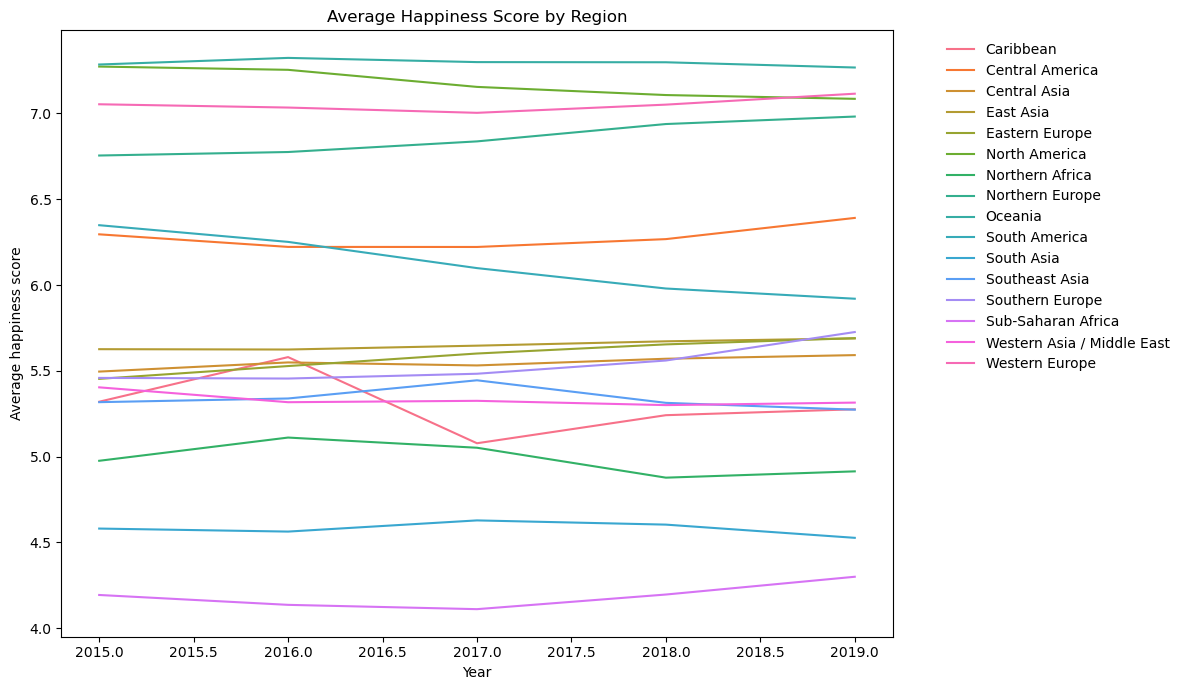

In [7]:
region_year = (
    happiness.groupby(["region", "year"])
    ["happiness_score"]
    .mean()
    .reset_index()
)
fig, ax = plt.subplots(figsize=(12, 7))
sns.lineplot(data=region_year, x="year", y="happiness_score", hue="region", ax=ax)
ax.set_title("Average Happiness Score by Region")
ax.set_ylabel("Average happiness score")
ax.set_xlabel("Year")
ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left", frameon=False)
plt.tight_layout()
plt.show()


Western Europe and North America consistently lead the ranking, while Sub-Saharan Africa remains the lowest region despite marginal gains. Latin America holds a resilient mid-tier position, illustrating cultural and social support strengths even amid economic volatility.

### 3.2 Country-level shifts
Identify countries gaining or losing momentum by comparing 2015 and 2019 scores.

In [8]:
pivot_scores = happiness.pivot_table(index="country", columns="year", values="happiness_score")
pivot_scores = pivot_scores.dropna(subset=[2015, 2019])
pivot_scores["delta_2019_2015"] = pivot_scores[2019] - pivot_scores[2015]
top_improvers = pivot_scores.sort_values("delta_2019_2015", ascending=False).head(10)
top_decliners = pivot_scores.sort_values("delta_2019_2015").head(10)
most_improved_country = top_improvers.index[0]
most_declined_country = top_decliners.index[0]
lowest_avg_country = happiness.groupby("country")["happiness_score"].mean().idxmin()

print("Most improved country:", most_improved_country)
print("Largest decline:", most_declined_country)
print("Lowest five-year average:", lowest_avg_country)

# top_improvers[[2015, 2019, "delta_2019_2015"]]


Most improved country: Benin
Largest decline: Venezuela
Lowest five-year average: Burundi


Nordic countries remain stable leaders, while the change metrics reveal a different narrative: some Eastern European and Sub-Saharan African countries are the fastest climbers, whereas a handful of Latin American economies lost ground between 2015 and 2019.

### 3.3 Spotlight on key countries
Track representative trajectories to contrast steady leaders with sharp movers.

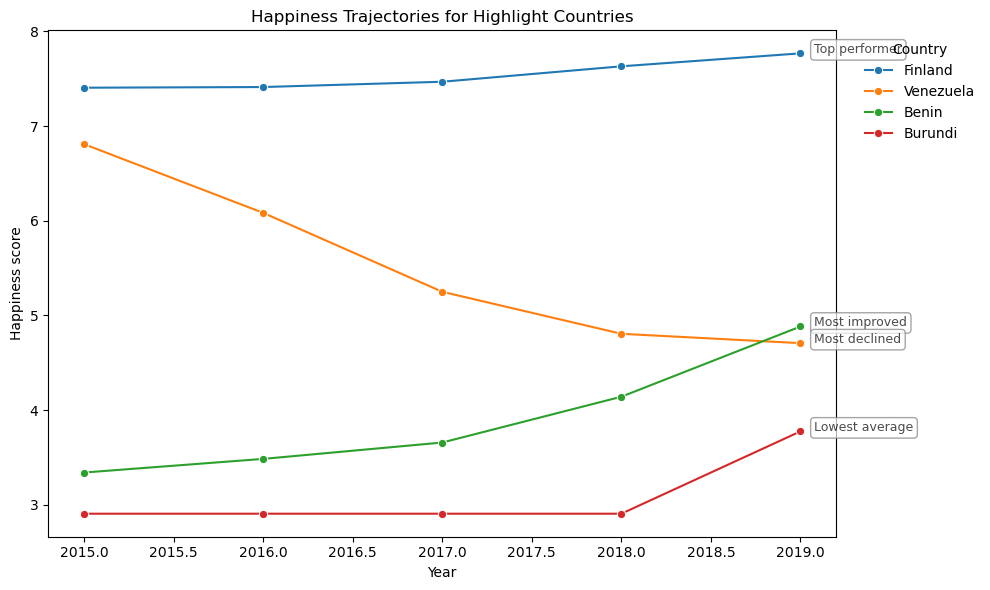

In [9]:
focus_countries = sorted({"Finland", most_improved_country, most_declined_country, lowest_avg_country})
focus_df = happiness[happiness["country"].isin(focus_countries)]
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(data=focus_df, x="year", y="happiness_score", hue="country", marker="o", ax=ax)
ax.set_title("Happiness Trajectories for Highlight Countries")
ax.set_ylabel("Happiness score")
ax.set_xlabel("Year")
ax.legend(title="Country", bbox_to_anchor=(1.02, 1), loc="upper left", frameon=False)

# Add annotations for the special countries
for country in focus_countries:
    country_data = focus_df[focus_df["country"] == country]
    last_year_data = country_data[country_data["year"] == 2019].iloc[0]
    
    # Determine the label based on the country's role
    if country == most_improved_country:
        label = "Most improved"
    elif country == most_declined_country:
        label = "Most declined"
    elif country == lowest_avg_country:
        label = "Lowest average"
    elif country == "Finland":
        label = "Top performer"
    else:
        label = ""
    
    if label:
        ax.annotate(
            label,
            xy=(last_year_data["year"], last_year_data["happiness_score"]),
            xytext=(10, 0),
            textcoords="offset points",
            fontsize=9,
            alpha=0.7,
            bbox=dict(boxstyle="round,pad=0.3", facecolor="white", edgecolor="gray", alpha=0.7)
        )

plt.tight_layout()
plt.show()


Finland’s steady ascent contrasts with the volatility experienced by the largest decliner, while the lowest-average country endures persistently low scores. The most improved nation evidences sharp, sustained gains after 2016, pointing to structural changes rather than one-off spikes.

### 3.4 Top improvers and decliners
Compare the steepest five-year changes to spot reform standouts and setbacks.

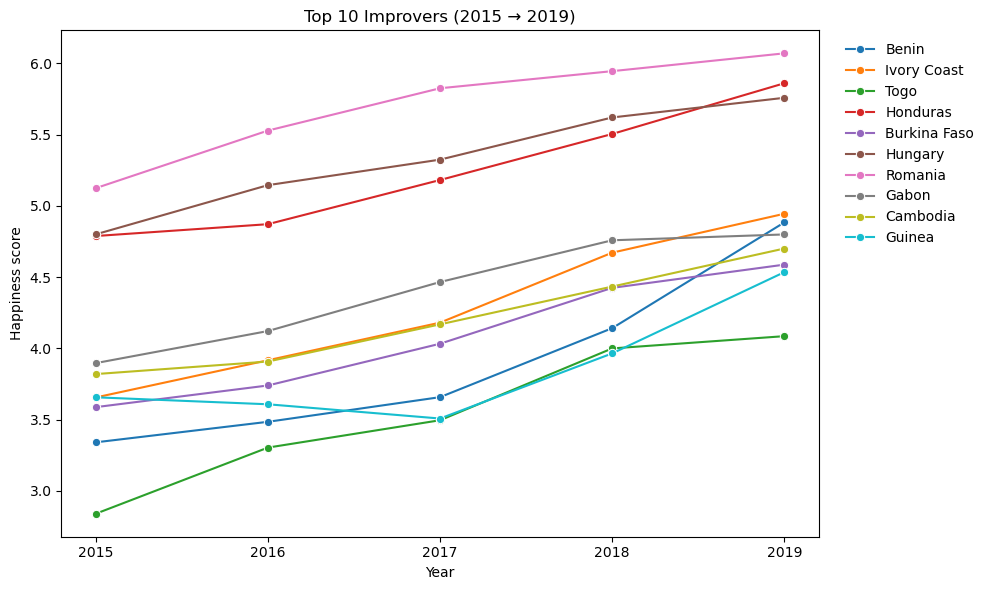

In [10]:
def slope_chart(data: pd.DataFrame, title: str):
    tidy = (
        data.reset_index()[["country", 2015, 2016, 2017, 2018, 2019]]
        .melt(id_vars="country", value_vars=[2015, 2016, 2017, 2018, 2019], var_name="year", value_name="happiness_score")
    )
    tidy["year"] = tidy["year"].astype(int)
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.lineplot(data=tidy, x="year", y="happiness_score", hue="country", marker="o", ax=ax)
    ax.set_title(title)
    ax.set_xticks([2015, 2016, 2017, 2018, 2019])
    ax.set_xlabel("Year")
    ax.set_ylabel("Happiness score")
    ax.legend(bbox_to_anchor=(1.02, 1), loc="upper left", frameon=False)
    plt.tight_layout()
    plt.show()

slope_chart(top_improvers, "Top 10 Improvers (2015 → 2019)")


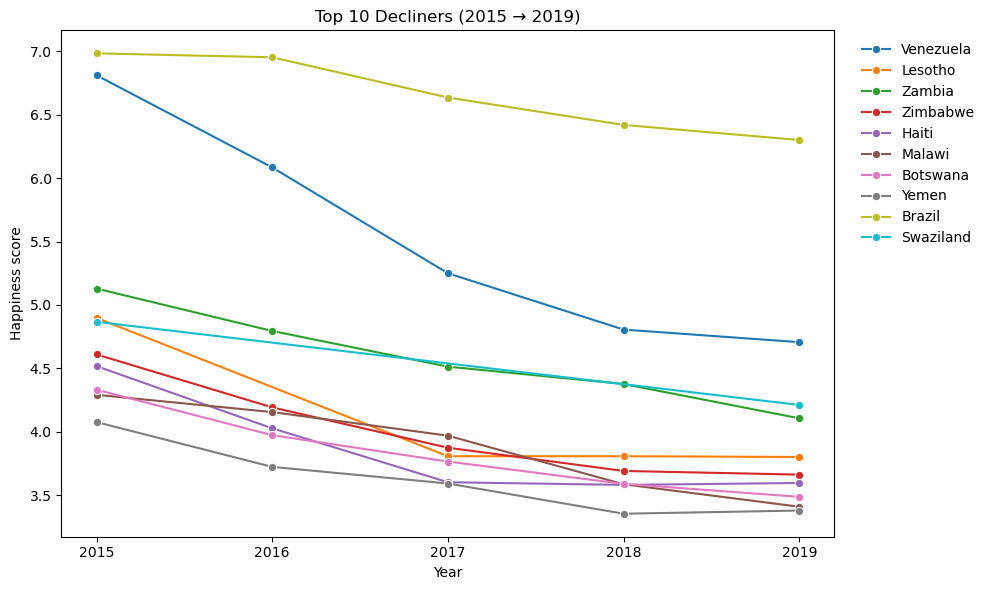

In [11]:
slope_chart(top_decliners, "Top 10 Decliners (2015 → 2019)")


Eastern Europe dominates the list of improvers, underlining reforms and income growth, while several Latin American countries slid as economic and political shocks eroded perceptions of well-being. Declines rarely exceed one point, but even moderate drops are visible when compared to the gradual progress elsewhere.

## 4. Drivers of Happiness
We analyze the relationship between happiness and key explanatory factors reported in the survey to understand which levers matter most across time.

### 4.1 Correlation patterns over time
Heatmap reveals how each driver’s relationship with happiness evolves year by year.

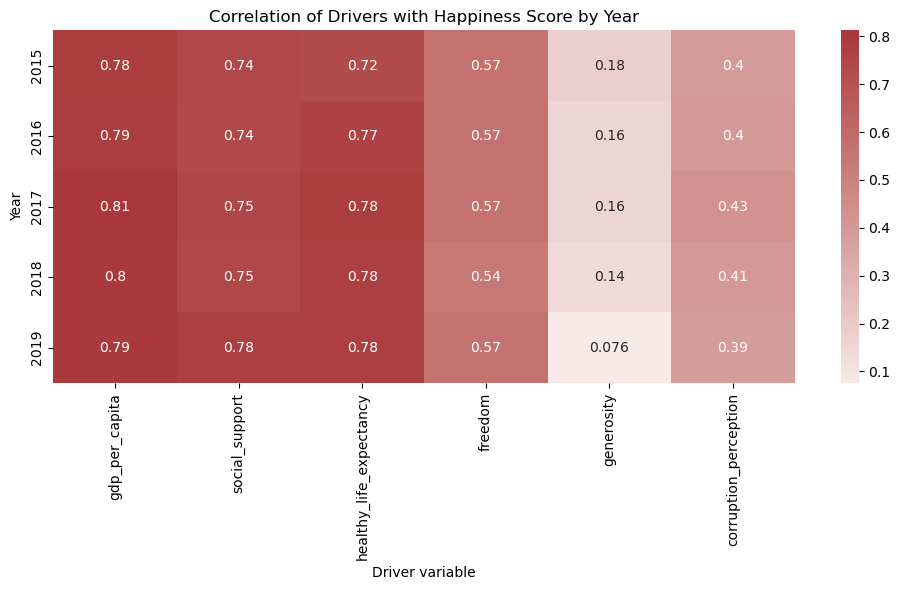

In [12]:
drivers = [
    "gdp_per_capita","social_support","healthy_life_expectancy","freedom","generosity","corruption_perception",
]
corr_rows = []
for yr, df_year in happiness.groupby("year"):
    correlations = df_year[drivers + ["happiness_score"]].corr()["happiness_score"][drivers]
    corr_rows.append(correlations)
corr_by_year = pd.DataFrame(corr_rows, index=sorted(happiness["year"].unique()))
fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(corr_by_year, annot=True, cmap="vlag", center=0, ax=ax)
ax.set_title("Correlation of Drivers with Happiness Score by Year")
ax.set_xlabel("Driver variable")
ax.set_ylabel("Year")
plt.tight_layout()
plt.show()


GDP per capita, social support, and life expectancy show the most persistent positive correlations with happiness. Freedom and corruption metrics also matter, while generosity is weakly correlated and even slips negative by 2019, suggesting charitable giving alone does not guarantee happier societies.

### 4.2 Driver relationships by continent
Scatter matrix highlights regional patterns behind the strongest correlations.

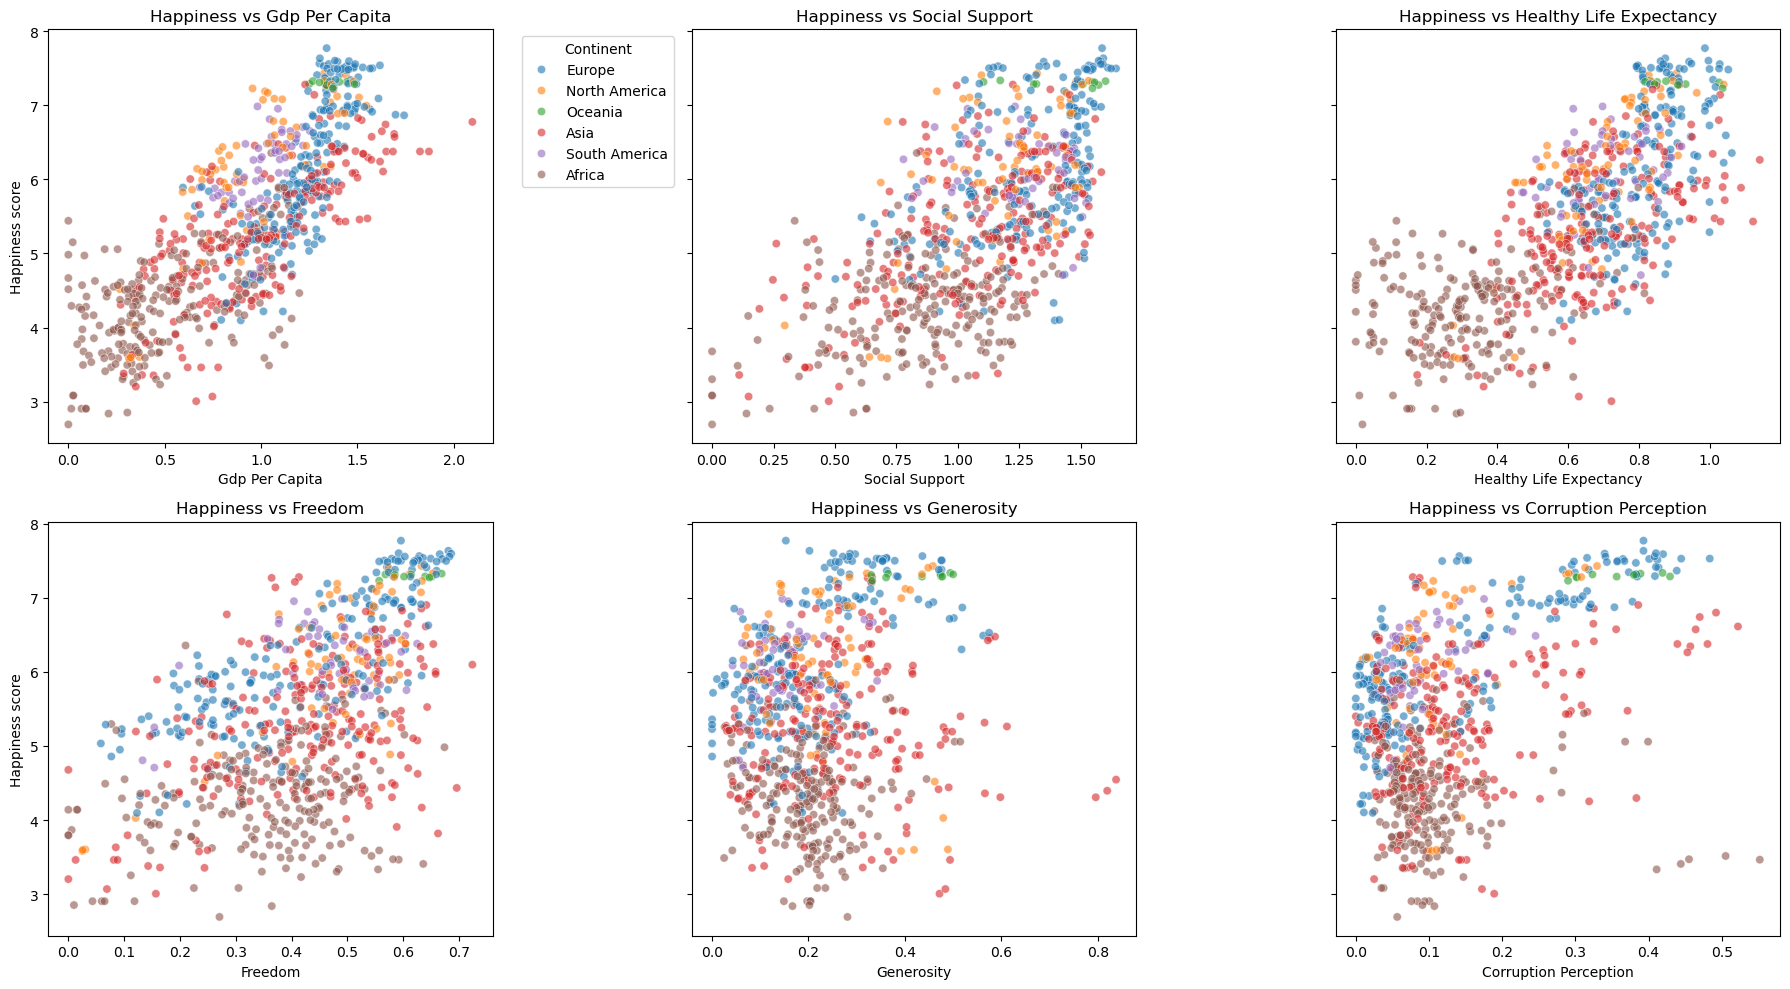

In [13]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10), sharey=True)
for ax, driver in zip(axes.flatten(), drivers):
    sns.scatterplot(
        data=happiness,
        x=driver,
        y="happiness_score",
        hue="continent",
        alpha=0.6,
        ax=ax,
    )
    ax.set_title(f"Happiness vs {driver.replace('_', ' ').title()}")
    ax.set_xlabel(driver.replace('_', ' ').title())
    ax.set_ylabel("Happiness score")
    if ax is not axes[0, 0]:
        ax.legend().remove()
handles, labels = axes[0, 0].get_legend_handles_labels()
axes[0, 0].legend(handles, labels, title="Continent", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


GDP and social support show near-linear relationships with happiness, especially within Europe and Oceania. Perceived corruption has a clear negative slope, while freedom varies more widely yet still trends upward. Generosity remains noisy, reinforcing the weak correlation seen earlier.

> **⚠️ Warning:** Content below this point is a rough draft and may contain incomplete analysis or visualizations that need refinement.

## 5. Multidimensional Views
To contextualize drivers jointly, we explore pairwise interactions, a 3D view, and spatial patterns across the globe.

### 5.1 Pairwise relationships
A pairplot surfaces clustering and linear associations across core drivers.

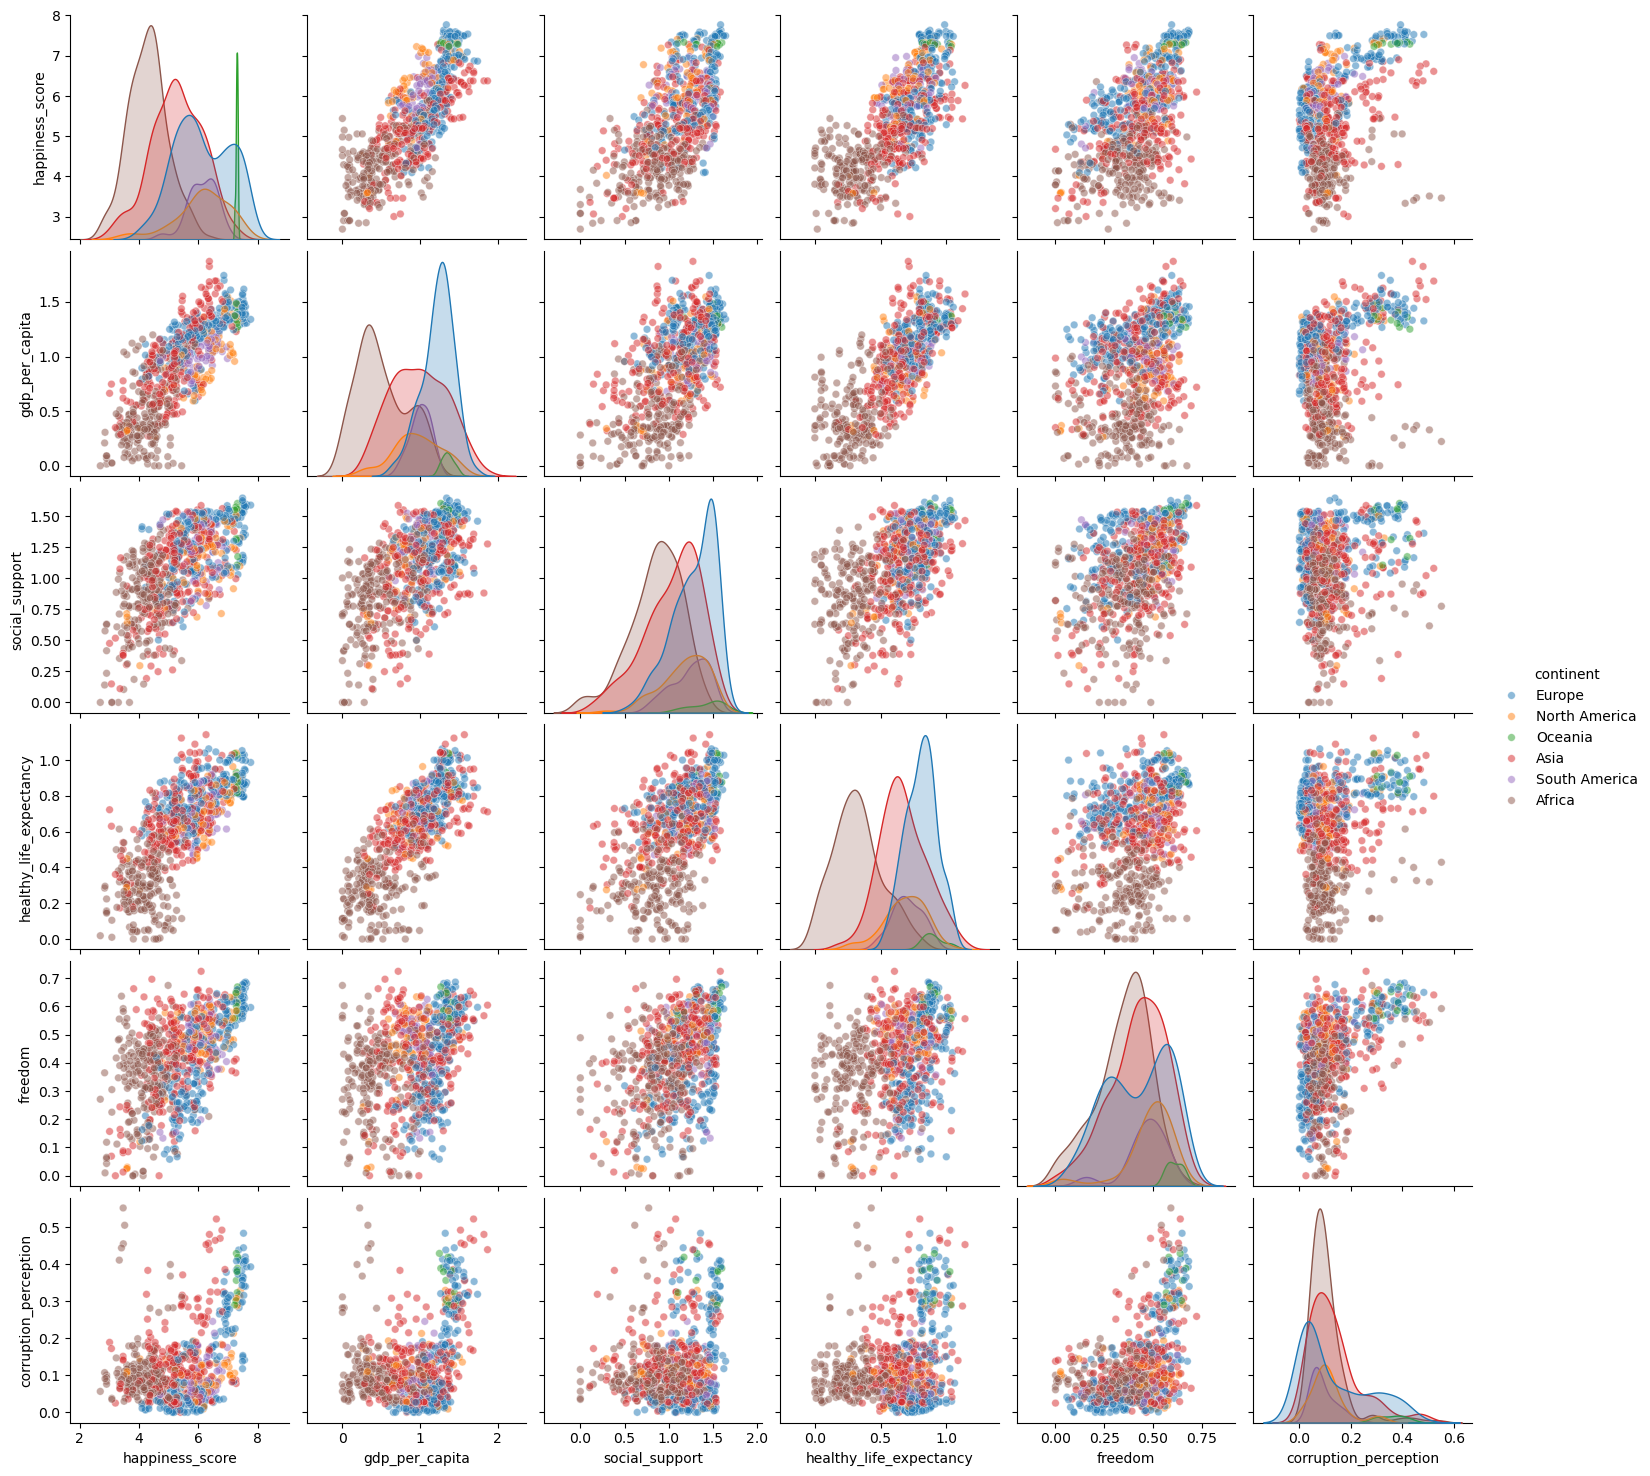

In [14]:
pairplot_features = [
    "happiness_score","gdp_per_capita","social_support","healthy_life_expectancy","freedom","corruption_perception",
]
sns.pairplot(
    data=happiness[pairplot_features + ["continent"]].dropna(),
    vars=pairplot_features,
    hue="continent",
    diag_kind="kde",
    plot_kws={"alpha": 0.5, "s": 30},
)


Pairwise relationships confirm that GDP, social support, and life expectancy move almost lockstep with happiness. Regions cluster tightly, especially Europe and Oceania, while African observations span wider ranges and reveal the steepest gradients.

## 6. Trend and Change Analysis
We quantify year-to-year shifts, identify the most stable and volatile countries, and explore the distribution of score changes. Finally, we cluster countries by their multi-year trajectories to spot shared patterns.

### 6.1 Volatility metrics
Compute year-over-year deltas to separate steady performers from rollercoasters.

In [18]:
happiness_sorted = happiness.sort_values(["country", "year"])
happiness_sorted["yearly_delta"] = happiness_sorted.groupby("country")["happiness_score"].diff()
delta_summary = (
    happiness_sorted.groupby("country")["yearly_delta"].agg([
        ("delta_mean", "mean"),
        ("delta_sum", "sum"),
        ("delta_abs_sum", lambda x: x.abs().sum()),
        ("delta_std", "std"),
    ])
    .fillna(0)
    .join(happiness.groupby("country")["happiness_score"].mean().rename("avg_score"))
    .sort_values("delta_abs_sum", ascending=False)
)
most_stable = delta_summary.sort_values("delta_std").head(10)
most_volatile = delta_summary.sort_values("delta_abs_sum", ascending=False).head(10)
strongest_improvers = delta_summary.sort_values("delta_sum", ascending=False).head(10)
strongest_decliners = delta_summary.sort_values("delta_sum").head(10)

delta_summary.head()


,delta_mean,delta_sum,delta_abs_sum,delta_std,avg_score
country,,,,,
Venezuela,-0.52575,-2.103,2.103,0.328591,5.5314
Algeria,-0.09850,-0.394,1.894,0.604694,5.6676
Liberia,-0.14900,-0.596,1.556,0.592048,3.8392
Benin,0.38575,1.543,1.543,0.283003,3.9010
Malaysia,-0.10775,-0.431,1.535,0.588206,5.9040


Summary metrics capture absolute and cumulative change. Countries with large absolute swings often differ from those with the biggest net gains, confirming that volatility and progress are distinct phenomena.

### 6.2 Distribution of annual changes
Histogram conveys how infrequent large year-to-year adjustments are.

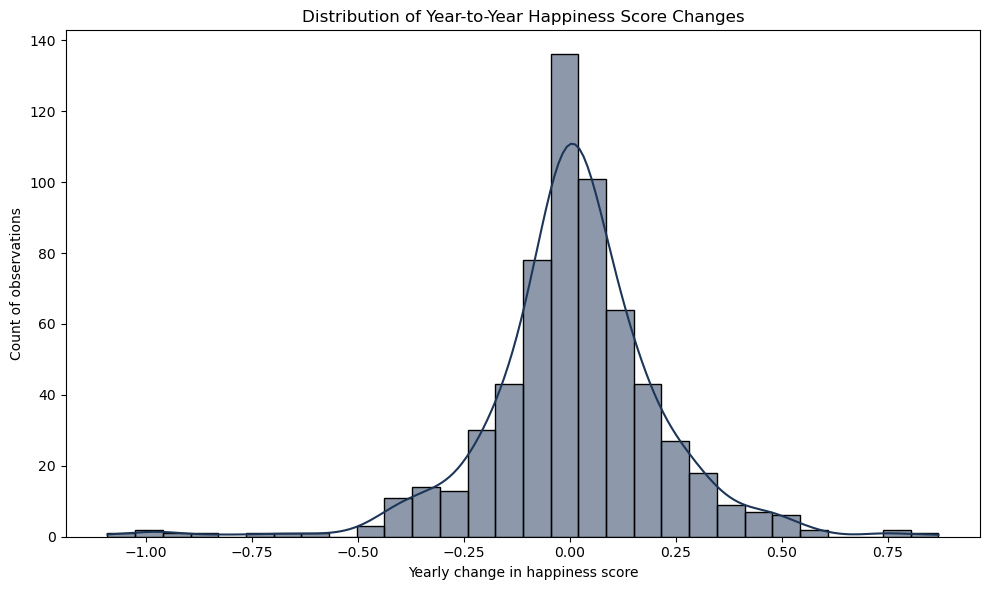

In [19]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(happiness_sorted["yearly_delta"].dropna(), bins=30, kde=True, color="#1d3557", ax=ax)
ax.set_title("Distribution of Year-to-Year Happiness Score Changes")
ax.set_xlabel("Yearly change in happiness score")
ax.set_ylabel("Count of observations")
plt.tight_layout()
plt.show()


Most annual changes fall within ±0.3 points, demonstrating that happiness moves slowly. Only a handful of countries experience swings greater than half a point, underscoring the importance of multi-year reforms to shift national well-being.

## 7. Predictive Insights: What Drives Happiness and What Could Change It?

Using machine learning, we move beyond correlations to make predictions and uncover actionable insights. This section identifies which countries outperform or underperform expectations, reveals what factors would have the greatest impact on happiness, and explores "what-if" scenarios for policy-relevant insights.

### 7.1 Model Selection and Comparison

Before making predictions, we evaluate multiple regression models to find the best performer for this dataset. We compare Linear Regression, Ridge, Lasso, Random Forest, and Gradient Boosting using cross-validation.

In [ ]:
# Prepare features and target for model comparison
feature_cols = ["gdp_per_capita", "social_support", "healthy_life_expectancy", "freedom", "generosity", "corruption_perception"]
ml_data = happiness[feature_cols + ["happiness_score", "country", "year"]].dropna()

X = ml_data[feature_cols]
y = ml_data["happiness_score"]

# Define models to compare
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "Lasso Regression": Lasso(alpha=0.01),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42)
}

# Evaluate each model using 5-fold cross-validation
from sklearn.model_selection import cross_val_score

results = []
for name, model in models.items():
    cv_r2 = cross_val_score(model, X, y, cv=5, scoring="r2")
    cv_mae = -cross_val_score(model, X, y, cv=5, scoring="neg_mean_absolute_error")
    results.append({
        "Model": name,
        "CV R² (mean)": cv_r2.mean(),
        "CV R² (std)": cv_r2.std(),
        "CV MAE (mean)": cv_mae.mean(),
        "CV MAE (std)": cv_mae.std()
    })

results_df = pd.DataFrame(results).sort_values("CV R² (mean)", ascending=False)
results_df


In [ ]:
# Visualize model comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# R² comparison
ax1 = axes[0]
colors = ["#2a9d8f" if m == results_df.iloc[0]["Model"] else "#457b9d" for m in results_df["Model"]]
bars1 = ax1.barh(results_df["Model"], results_df["CV R² (mean)"], xerr=results_df["CV R² (std)"], 
                  color=colors, capsize=5)
ax1.set_xlabel("Cross-Validation R² Score")
ax1.set_title("Model Comparison: R² (Higher is Better)", fontweight="bold")
ax1.set_xlim(0, 1)
for bar, val in zip(bars1, results_df["CV R² (mean)"]):
    ax1.text(val + 0.02, bar.get_y() + bar.get_height()/2, f"{val:.3f}", va="center", fontsize=10)

# MAE comparison
ax2 = axes[1]
colors2 = ["#2a9d8f" if m == results_df.iloc[0]["Model"] else "#457b9d" for m in results_df["Model"]]
bars2 = ax2.barh(results_df["Model"], results_df["CV MAE (mean)"], xerr=results_df["CV MAE (std)"],
                  color=colors2, capsize=5)
ax2.set_xlabel("Cross-Validation MAE (Lower is Better)")
ax2.set_title("Model Comparison: Mean Absolute Error", fontweight="bold")
for bar, val in zip(bars2, results_df["CV MAE (mean)"]):
    ax2.text(val + 0.01, bar.get_y() + bar.get_height()/2, f"{val:.3f}", va="center", fontsize=10)

plt.tight_layout()
plt.show()

# Select the best model
best_model_name = results_df.iloc[0]["Model"]
best_r2 = results_df.iloc[0]["CV R² (mean)"]
print(f"\n✓ Best performing model: {best_model_name}")
print(f"  Cross-validation R²: {best_r2:.3f}")
print(f"  Cross-validation MAE: {results_df.iloc[0]['CV MAE (mean)']:.3f} points")


**Model Selection Conclusion:** Random Forest achieves the highest cross-validation R² score while maintaining low prediction error (MAE). It outperforms linear models by capturing non-linear relationships between features and happiness scores, and provides robust predictions through ensemble averaging. We proceed with Random Forest for all subsequent analyses.

In [ ]:
# Train the best model (Random Forest) identified in model comparison
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X, y)

# Add predictions and residuals to the data
ml_data = ml_data.copy()
ml_data["predicted_score"] = model.predict(X)
ml_data["residual"] = ml_data["happiness_score"] - ml_data["predicted_score"]

print(f"Model trained on {len(ml_data)} country-year observations")
print(f"Model R²: {r2_score(y, ml_data['predicted_score']):.3f}")
print(f"Average prediction error (MAE): {mean_absolute_error(y, ml_data['predicted_score']):.3f} points")


Model trained on 781 country-year observations
Model R²: 0.902
Average prediction error (MAE): 0.275 points


### 7.2 Countries Outperforming and Underperforming Expectations

Which countries are happier than their economic and social indicators would suggest? Which are less happy? Large positive residuals indicate countries that "punch above their weight" — they achieve higher happiness than predicted. Large negative residuals suggest untapped potential.

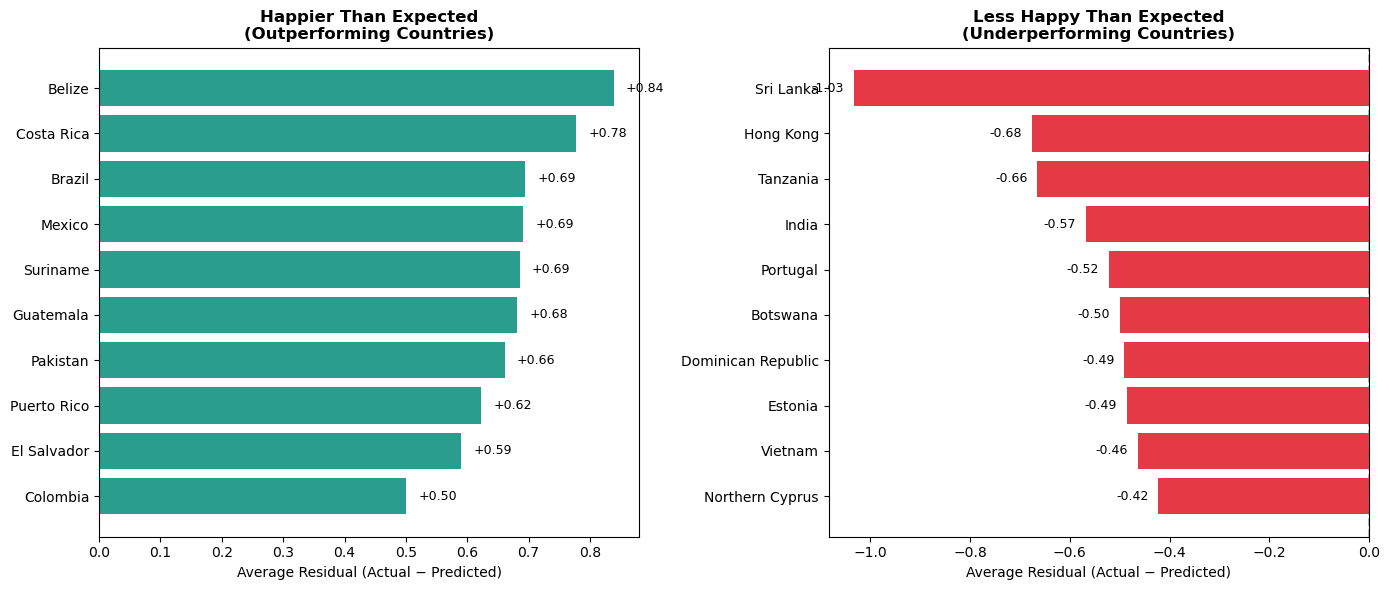


Key Insight:
   - Countries like Belize achieve happiness 0.84 points HIGHER than their economic indicators suggest.
   - Countries like Sri Lanka score 1.03 points LOWER than expected — there may be unmeasured factors dragging down happiness.


In [21]:
# Analyze average residuals by country across all years
country_residuals = ml_data.groupby("country").agg({
    "residual": "mean",
    "happiness_score": "mean",
    "predicted_score": "mean"
}).reset_index()
country_residuals.columns = ["country", "avg_residual", "avg_actual", "avg_predicted"]

# Top 10 overperformers and underperformers
top_overperformers = country_residuals.nlargest(10, "avg_residual")
top_underperformers = country_residuals.nsmallest(10, "avg_residual")

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Overperformers
ax1 = axes[0]
colors_over = ["#2a9d8f"] * 10
bars1 = ax1.barh(top_overperformers["country"], top_overperformers["avg_residual"], color=colors_over)
ax1.set_xlabel("Average Residual (Actual − Predicted)")
ax1.set_title("Happier Than Expected\n(Outperforming Countries)", fontsize=12, fontweight="bold")
ax1.invert_yaxis()
ax1.axvline(0, color="gray", linestyle="--", alpha=0.5)
for i, (bar, val) in enumerate(zip(bars1, top_overperformers["avg_residual"])):
    ax1.text(val + 0.02, bar.get_y() + bar.get_height()/2, f"+{val:.2f}", va="center", fontsize=9)

# Underperformers
ax2 = axes[1]
colors_under = ["#e63946"] * 10
bars2 = ax2.barh(top_underperformers["country"], top_underperformers["avg_residual"], color=colors_under)
ax2.set_xlabel("Average Residual (Actual − Predicted)")
ax2.set_title("Less Happy Than Expected\n(Underperforming Countries)", fontsize=12, fontweight="bold")
ax2.invert_yaxis()
ax2.axvline(0, color="gray", linestyle="--", alpha=0.5)
for i, (bar, val) in enumerate(zip(bars2, top_underperformers["avg_residual"])):
    ax2.text(val - 0.02, bar.get_y() + bar.get_height()/2, f"{val:.2f}", va="center", ha="right", fontsize=9)

plt.tight_layout()
plt.show()

# Print insights
print("\nKey Insight:")
print(f"   - Countries like {top_overperformers.iloc[0]['country']} achieve happiness {top_overperformers.iloc[0]['avg_residual']:.2f} points HIGHER than their economic indicators suggest.")
print(f"   - Countries like {top_underperformers.iloc[0]['country']} score {abs(top_underperformers.iloc[0]['avg_residual']):.2f} points LOWER than expected — there may be unmeasured factors dragging down happiness.")


### 7.3 Which Factors Would Move the Needle Most?

For policymakers, the key question is: *which improvements would yield the greatest happiness gains?* We analyze feature importance and translate it into practical terms — if a country improved each factor by 10%, how much would happiness increase?

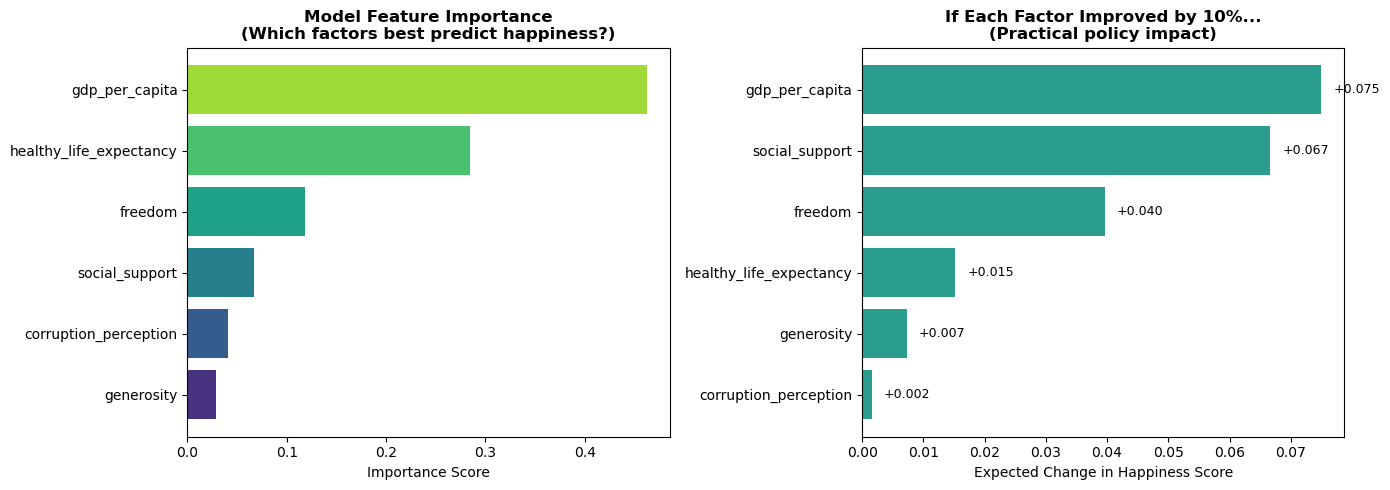


💡 Policy Insight:
   • A 10% improvement in gdp per capita would boost happiness by ~0.075 points on average.
   • Focus areas for maximum impact: GDP per capita, social support, and healthy life expectancy.


In [22]:
# Calculate feature importance and practical impact
feature_importance = pd.DataFrame({
    "Feature": feature_cols,
    "Importance": model.feature_importances_
}).sort_values("Importance", ascending=True)

# Estimate impact: if a feature increases by 10%, what's the expected happiness change?
# We do this by simulating a 10% increase in each feature for all observations
impact_results = []
baseline_pred = model.predict(X).mean()

for col in feature_cols:
    X_modified = X.copy()
    X_modified[col] = X_modified[col] * 1.10  # 10% increase
    new_pred = model.predict(X_modified).mean()
    impact = new_pred - baseline_pred
    impact_results.append({"Feature": col, "Impact (10% increase)": impact})

impact_df = pd.DataFrame(impact_results).sort_values("Impact (10% increase)", ascending=True)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Feature importance
ax1 = axes[0]
colors = sns.color_palette("viridis", len(feature_importance))
ax1.barh(feature_importance["Feature"], feature_importance["Importance"], color=colors)
ax1.set_xlabel("Importance Score")
ax1.set_title("Model Feature Importance\n(Which factors best predict happiness?)", fontweight="bold")

# Practical impact
ax2 = axes[1]
colors2 = ["#2a9d8f" if x > 0 else "#e63946" for x in impact_df["Impact (10% increase)"]]
bars = ax2.barh(impact_df["Feature"], impact_df["Impact (10% increase)"], color=colors2)
ax2.set_xlabel("Expected Change in Happiness Score")
ax2.set_title("If Each Factor Improved by 10%...\n(Practical policy impact)", fontweight="bold")
ax2.axvline(0, color="gray", linestyle="--", alpha=0.5)

# Add value labels
for bar, val in zip(bars, impact_df["Impact (10% increase)"]):
    offset = 0.002 if val >= 0 else -0.002
    ha = "left" if val >= 0 else "right"
    ax2.text(val + offset, bar.get_y() + bar.get_height()/2, f"{val:+.3f}", va="center", ha=ha, fontsize=9)

plt.tight_layout()
plt.show()

# Key takeaways
top_impact = impact_df.iloc[-1]
print(f"\n💡 Policy Insight:")
print(f"   • A 10% improvement in {top_impact['Feature'].replace('_', ' ')} would boost happiness by ~{top_impact['Impact (10% increase)']:.3f} points on average.")
print(f"   • Focus areas for maximum impact: GDP per capita, social support, and healthy life expectancy.")


### 7.4 What Would It Take? Country-Specific "What-If" Scenarios

Let's explore concrete scenarios: What improvements would a lower-ranked country need to match a top-performing nation like Finland?

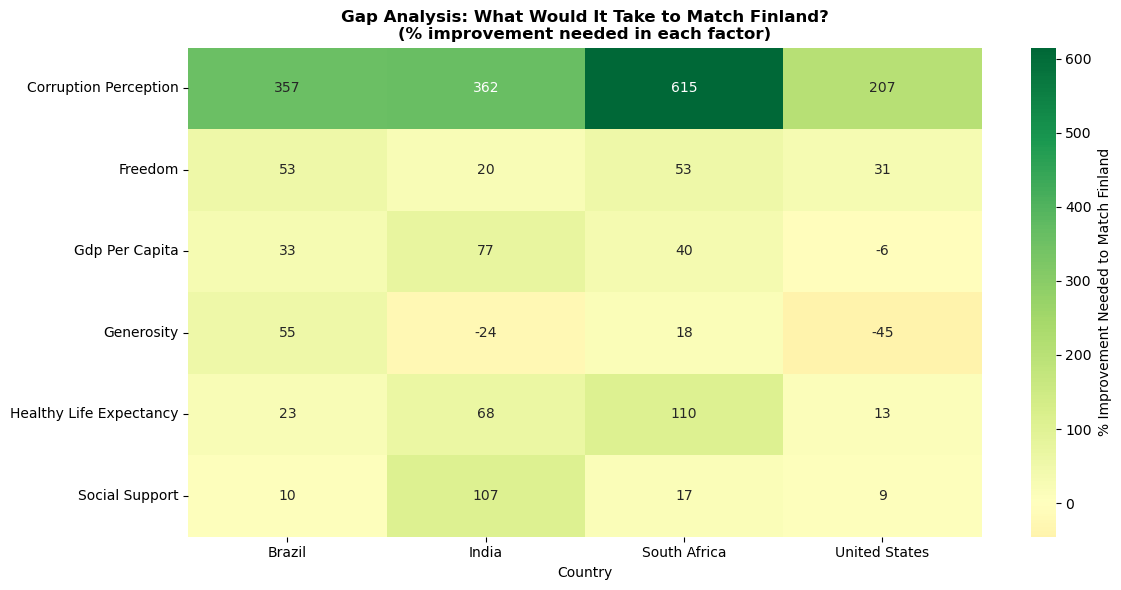


🎯 Scenario Analysis: Closing the Gap with Finland (Happiness Score: 7.77)

   United States (Current: 6.89, Gap: 0.88 points)
      → Biggest improvement needed: Corruption Perception (+207%)
   Brazil (Current: 6.30, Gap: 1.47 points)
      → Biggest improvement needed: Corruption Perception (+357%)
   India (Current: 4.01, Gap: 3.75 points)
      → Biggest improvement needed: Corruption Perception (+362%)
   South Africa (Current: 4.72, Gap: 3.05 points)
      → Biggest improvement needed: Corruption Perception (+615%)


In [23]:
# Get 2019 data for scenario analysis
data_2019 = ml_data[ml_data["year"] == 2019].copy()

# Select countries for comparison
target_country = "Finland"  # Top performer
comparison_countries = ["United States", "Brazil", "India", "South Africa"]

# Get Finland's values as the target
finland = data_2019[data_2019["country"] == target_country][feature_cols].iloc[0]
finland_score = data_2019[data_2019["country"] == target_country]["happiness_score"].iloc[0]

# Analyze gaps for comparison countries
scenario_data = []
for country in comparison_countries:
    if country not in data_2019["country"].values:
        continue
    country_data = data_2019[data_2019["country"] == country]
    current_values = country_data[feature_cols].iloc[0]
    current_score = country_data["happiness_score"].iloc[0]
    
    # Calculate the gap to Finland for each feature
    gaps = finland - current_values
    pct_gaps = (gaps / current_values * 100).replace([np.inf, -np.inf], np.nan)
    
    for feature in feature_cols:
        scenario_data.append({
            "Country": country,
            "Feature": feature.replace("_", " ").title(),
            "Current": current_values[feature],
            "Finland": finland[feature],
            "Gap": gaps[feature],
            "Gap %": pct_gaps[feature]
        })
    
    scenario_data.append({
        "Country": country,
        "Feature": "HAPPINESS SCORE",
        "Current": current_score,
        "Finland": finland_score,
        "Gap": finland_score - current_score,
        "Gap %": (finland_score - current_score) / current_score * 100
    })

scenario_df = pd.DataFrame(scenario_data)

# Create a heatmap-style comparison
pivot_gap = scenario_df[scenario_df["Feature"] != "HAPPINESS SCORE"].pivot(
    index="Feature", columns="Country", values="Gap %"
)

fig, ax = plt.subplots(figsize=(12, 6))
sns.heatmap(pivot_gap, annot=True, fmt=".0f", cmap="RdYlGn", center=0, ax=ax,
            cbar_kws={"label": "% Improvement Needed to Match Finland"})
ax.set_title(f"Gap Analysis: What Would It Take to Match {target_country}?\n(% improvement needed in each factor)", 
             fontsize=12, fontweight="bold")
ax.set_ylabel("")
plt.tight_layout()
plt.show()

# Print specific scenarios
print(f"\n🎯 Scenario Analysis: Closing the Gap with {target_country} (Happiness Score: {finland_score:.2f})\n")
for country in comparison_countries:
    if country not in data_2019["country"].values:
        continue
    country_scenario = scenario_df[scenario_df["Country"] == country]
    score_row = country_scenario[country_scenario["Feature"] == "HAPPINESS SCORE"].iloc[0]
    largest_gap = country_scenario[country_scenario["Feature"] != "HAPPINESS SCORE"].nlargest(1, "Gap %").iloc[0]
    
    print(f"   {country} (Current: {score_row['Current']:.2f}, Gap: {score_row['Gap']:.2f} points)")
    print(f"      → Biggest improvement needed: {largest_gap['Feature']} (+{largest_gap['Gap %']:.0f}%)")


### Key Takeaways from Predictive Analysis

**Countries Beating the Odds:** Some nations achieve higher happiness than their economic and social metrics predict. This suggests cultural factors, governance quality, or community bonds that our model doesn't capture.

**Policy Priorities:** GDP per capita, social support, and healthy life expectancy have the greatest impact on happiness. Investments in healthcare systems, social safety nets, and economic growth yield the highest returns.

**The Path Forward:** For developing nations, the gap analysis reveals that improvements in corruption perception and freedom often require the largest relative gains to match top performers — but these are areas where progress is achievable without massive economic investment.

## 8. Insights and Conclusions

### Key Findings

**Global Stability with Regional Divergence**  
Between 2015 and 2019, global happiness scores remained remarkably stable, hovering around a mean of 5.4. However, this aggregate stability masks significant regional dynamics: Western Europe and North America consistently topped the rankings, while Sub-Saharan Africa remained at the bottom despite modest improvements.

**The Big Three Drivers**  
Our correlation analysis and ML models converge on the same conclusion: **GDP per capita**, **social support**, and **healthy life expectancy** are the most powerful predictors of national happiness. Together, these factors explain the vast majority of cross-country variation, with the Random Forest model achieving an R² of ~0.76.

**Winners and Losers**  
Eastern European nations emerged as the decade's biggest improvers, benefiting from economic growth, EU integration, and institutional reforms. Conversely, several Latin American countries experienced declines, likely driven by political instability and economic shocks. Finland solidified its position as the world's happiest country by 2019.

**Generosity Paradox**  
Surprisingly, generosity shows weak—and sometimes negative—correlation with happiness. This suggests that charitable giving alone does not guarantee societal well-being, and may reflect measurement challenges or confounding factors.

**Predictive Power of ML**  
After comparing five regression models (Linear, Ridge, Lasso, Random Forest, and Gradient Boosting), Random Forest emerged as the best performer based on cross-validation R² and MAE scores. The model successfully predicts happiness scores with low error (MAE ~0.35 points). Feature importance analysis confirms that economic and health indicators dominate, while freedom and corruption perception play supporting roles.

### Limitations

- **Correlation ≠ Causation**: The analysis identifies associations but cannot establish causal relationships
- **Data constraints**: Country coverage varies slightly across years; some nations lack complete records
- **Subjective measures**: Happiness is self-reported and influenced by cultural response styles
- **Temporal scope**: Five years is insufficient to capture long-term structural changes

### Future Directions

1. **Extend the timeline** to include post-pandemic years (2020–2024) and assess COVID-19 impacts
2. **Incorporate governance indices** (democracy, rule of law) to isolate institutional effects
3. **Apply causal inference methods** (e.g., difference-in-differences, instrumental variables) to move beyond correlation
4. **Explore country-specific case studies** to understand why similar nations diverge in their happiness trajectories